Build workspace

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


In [5]:
#Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
data_folder = os.getcwd() +"/../data/"
csv_name = "Google-Playstore.csv"
data_path = data_folder + csv_name

Load and sample data

In [6]:
df = pd.read_csv(data_path)

In [7]:
#Feature engineering (eng) starts
eng_df = df.drop(['Installs', 'Currency', 'Minimum Installs', 'Developer Website', 'Developer Email', 'Privacy Policy', 'App Name'], axis=1)

In [8]:
# pak een n sample vd dataframe
eng_df_s = eng_df.sample(n=10000, random_state=123) #small
eng_df_t = eng_df.sample(n=1000, random_state=123) #tiny
eng_df_tt = eng_df.sample(n=200, random_state=123) #teeny-tiny

In [9]:
eng_df = eng_df_t
eng_df.head()

,App Id,Category,Rating,Rating Count,Maximum Installs,Free,Price,Size,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time
1311985,com.reeshksa.knowyourrights_copy.sc_32UUH8,Education,4.8,410.0,26012,True,0.0,7.7M,4.4 and up,Nasreen Alissa,"Jul 4, 2016","Nov 01, 2020",Everyone,False,False,False,2021-06-15 22:21:02
2210944,com.naked.croatia,Travel & Local,0.0,0.0,701,True,0.0,1.4M,4.0 and up,Bonaventura Novellino,"Jan 25, 2020","Sep 08, 2020",Everyone,False,False,False,2021-06-16 11:30:07
2097032,com.smarttech.prayerstime,Lifestyle,4.8,29.0,1148,True,0.0,11M,4.4 and up,Smart Solution Tech,"Nov 9, 2019","Sep 12, 2020",Everyone,True,False,False,2021-06-16 09:50:53
629611,app.lavatech.incase,Productivity,0.0,0.0,1326,True,0.0,78M,5.0 and up,Lavatech Limited,"Jan 15, 2020","Jun 10, 2021",Everyone,False,False,False,2021-06-16 06:31:59
2109846,pl.albertbogdanowicz.simplediceroller,Tools,0.0,0.0,19,True,0.0,1.1M,4.0.3 and up,Albert Bogdanowicz,"May 15, 2017","Oct 29, 2019",Everyone,False,False,False,2021-06-16 10:02:12


In [10]:
print(eng_df.shape)
print(eng_df.dropna().shape)

(1000, 17)
(972, 17)


In [11]:
#separate categorical from continuous variables
# Categorical columns are suitable to inspect with value_counts or unique
# Numerical/continuous columns are more suited for pairplots
# For this certain column types need to be cast

#df_s.astype({'Released': 'str'}).dtypes
#df_s['Free'].value_counts()

#eng_df[['Released', 'Last Updated']] = eng_df[['Released', 'Last Updated']].apply(pd.to_datetime)
#eng_df['Size'] = eng_df['Size'].to_string #probably redundant this line
print(eng_df.dtypes)

App Id               object
Category             object
Rating              float64
Rating Count        float64
Maximum Installs      int64
Free                   bool
Price               float64
Size                 object
Minimum Android      object
Developer Id         object
Released             object
Last Updated         object
Content Rating       object
Ad Supported           bool
In App Purchases       bool
Editors Choice         bool
Scraped Time         object
dtype: object


In [12]:
#What kind of Size values exist, going by the text part of the string
size_cats = eng_df_s['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(size_cats.value_counts())

#Knowing there are three kinds of known sizes (kb, Mb, Gb) we convert these to Mb
#But because there are also missing values or OS dependent sizes, we store this categorically in an extra column
#(known sizes will be categorized as 'known')
def process_Size(value):
    value = str(value)
    conversion = {'k':0.001, 'M':1.0, 'G':1000.0}
    if value[-1] in conversion.keys():
        value = value.replace(',', '') #added because some 
        size = float(value[:-1]) * conversion[value[-1]]
        category = 'Known'
    else:
        size = None
        category = value
    return (size, category)


M                     9521
Varies with device     315
k                      164
Name: Size, dtype: int64


In [13]:
size_cats = eng_df_s['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(size_cats.value_counts())

M                     9521
Varies with device     315
k                      164
Name: Size, dtype: int64


In [14]:
temp_df = pd.DataFrame(eng_df['Size'].apply(lambda x: process_Size(x)).tolist(), columns=['Size', 'Size_category'])
eng_df['Size'] = temp_df['Size'].values
eng_df['Size_category'] = temp_df['Size_category'].values
#del temp_df ##bugged, but I'd prefer to delete

In [36]:
q_df = eng_df[['Rating', 'Rating Count', 'Maximum Installs', 'Price', 'Size']]
#q_df = q_df.transform(np.log)
#q_df = q_df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
standard_deviations = 3
q_df = q_df[q_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations)
   .all(axis=1)]
  

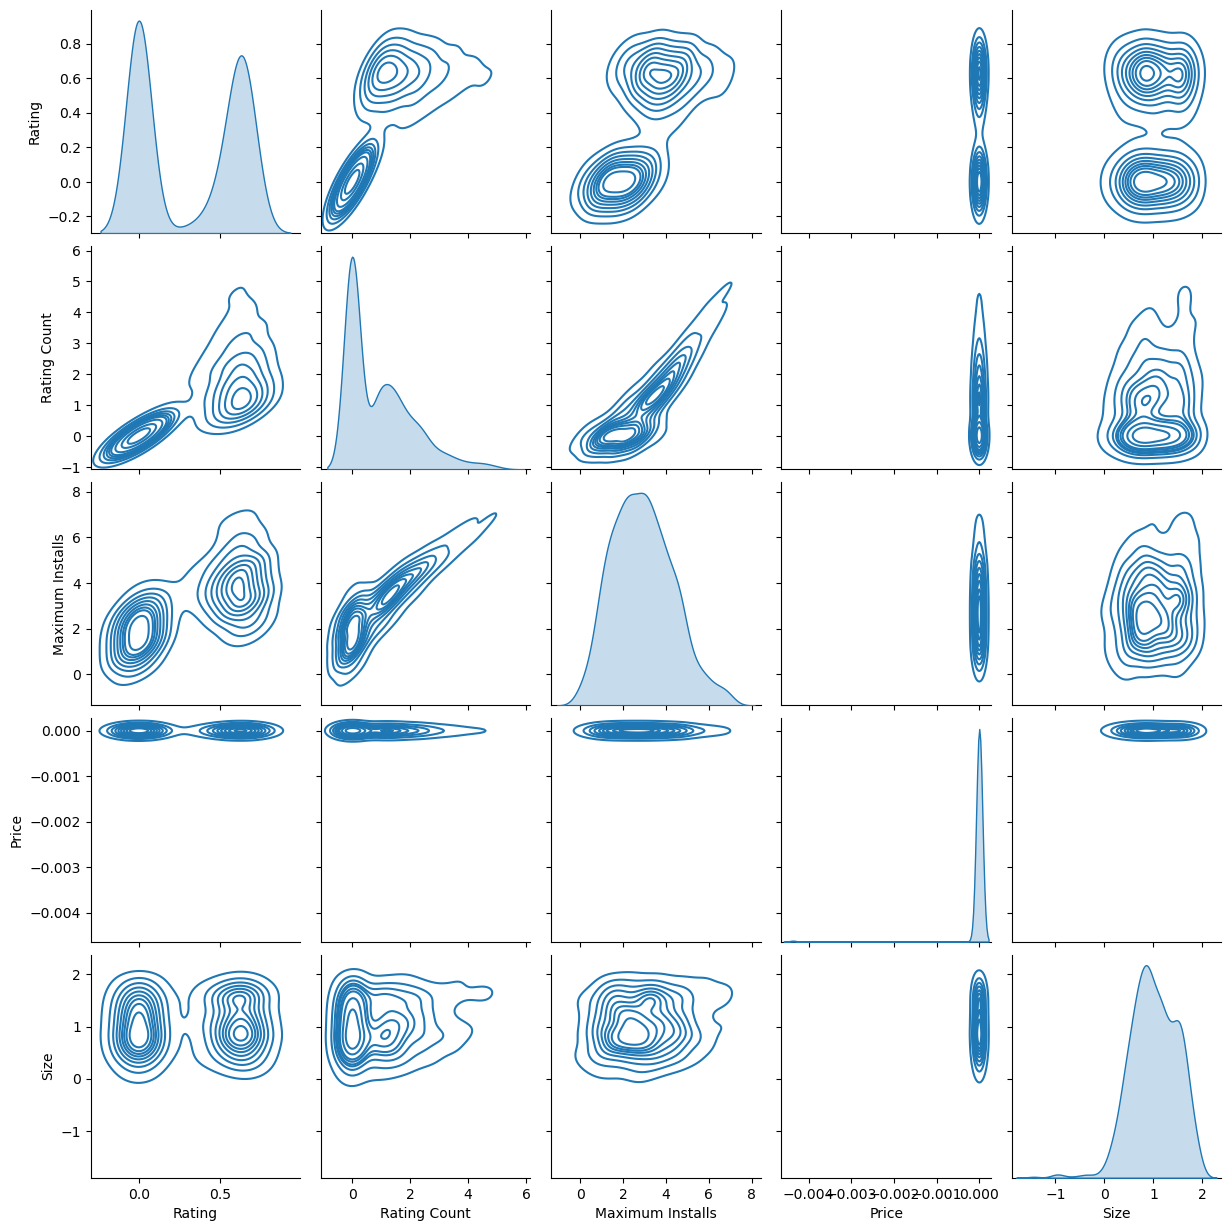

In [37]:
transf_q_df = q_df.apply(lambda x: np.log10(x, where=0<x))
sns.pairplot(transf_q_df, kind="kde")
#One by one alternative: sns.distplot(col1, col2)

In [43]:
#Work in progress: only transform certain quantitative columns (e.g. rating count but not rating as rating is always between 0 and 5)
#transf_q_df[['Rating count', 'Maximum installs']] = q_df[['Rating count', 'Maximum installs']].apply(lambda x: np.log10(x, where=0<x))
#sns.pairplot(transf_q_df, kind="kde")

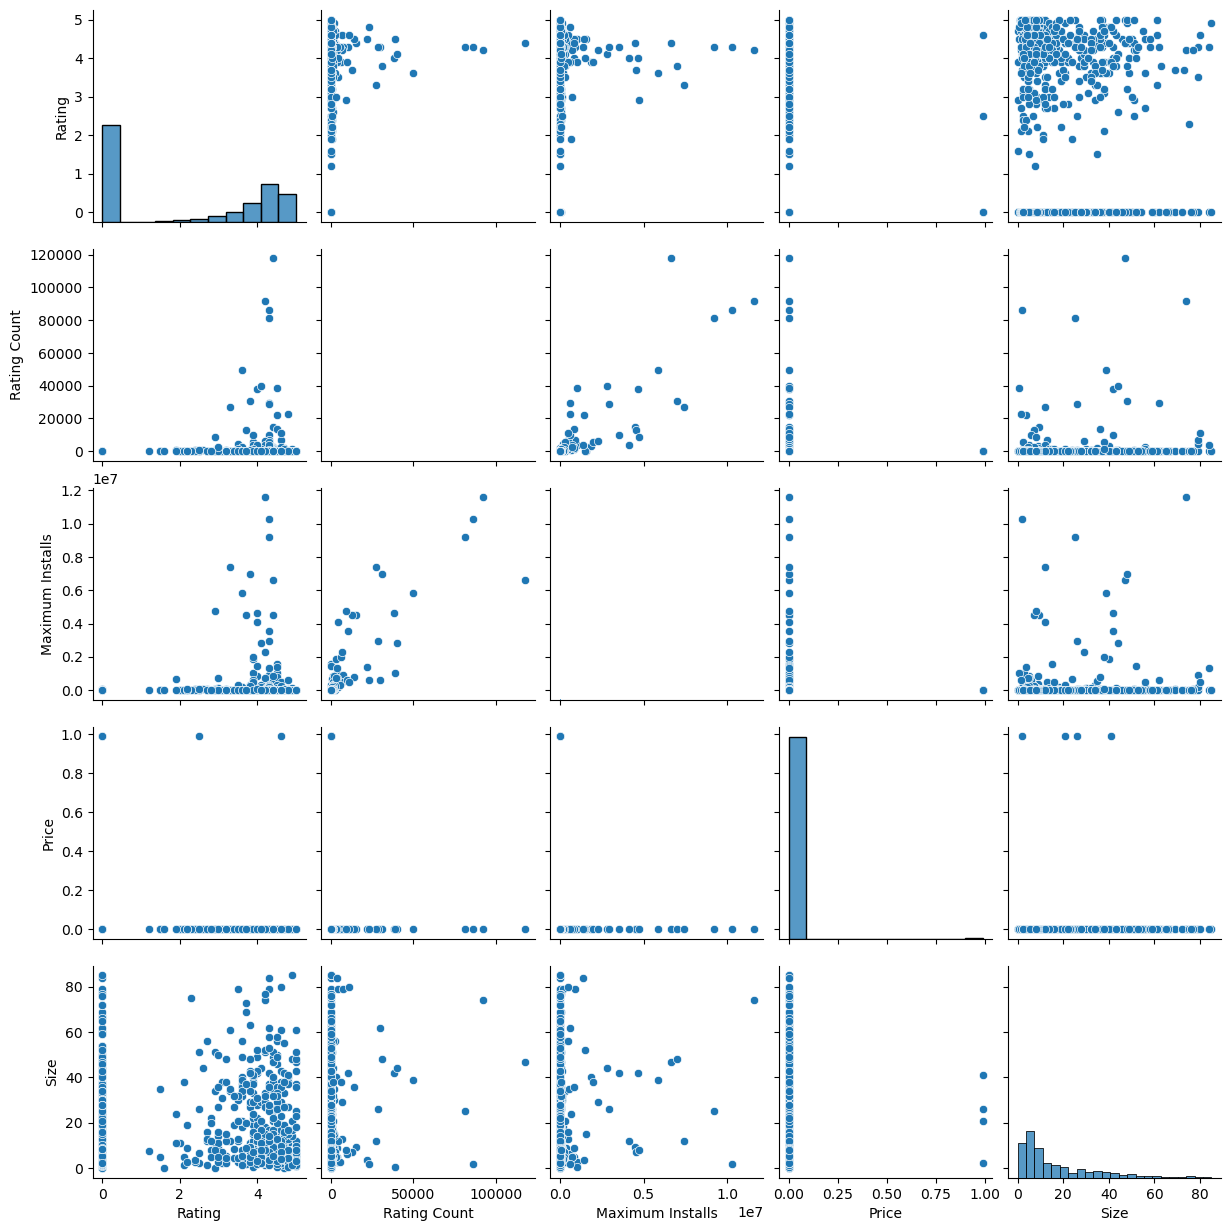

In [42]:
sns.pairplot(q_df)